# TF Single Equality Constrained Quadratic Optimizing

This notebook demonstrates a single equality constrained quadratic programming problem solver using TensorFlow.

The approach adds a penalty in addition to the augmented Lagrangian equation.
The Lagrangian $\lambda$ value is successively approximated and as
the solution is approached, the penalty increases.

## Review

The quadratic programming problem is to minimize:
$$
\frac{1}{2} x^t A x + b^{t}x,\space x \in \mathbb{R}^2
$$

subject to:

$$
C x + d = 0,\space x \in \mathbb{R}^2
$$

Consider just one constraint, for example:

$$
\begin{align}
Minimize\ && f(x) = \ 2x_1^2 + x_2^2\label{P1}\tag{P1}\\
subject\ to\ && x_1 + x_2 = 1
\end{align}
$$

The Lagrangian is:
$$
L(x_1, x_2, \lambda_1, \lambda_2) = 2x_1^2 + x_2^2 - \lambda_1(x_1 + x_2 -1)
$$

Let $x^*$, $\lambda^*$ be the solution. Then:

$$
\begin{align}
\frac{\partial L}{\partial x_1}(x_1^*, x_2^*, \lambda_1^*) =&&
4x_1^* && &&- \lambda_1^* && &&= 0\label{d1}\tag{1}\\
\frac{\partial L}{\partial x_2}(x_1^*, x_2^*, \lambda_1^*) =&&
&& 2x_2^* &&- \lambda_1^* && &&= 0\label{d2}\tag{2}\\
\frac{\partial L}{\partial \lambda_1}(x_1^*, x_2^*, \lambda_1^*) =&&
x_1^* &&+ x_2^* && &&- 1 &&= 0\label{d3}\tag{3}
\end{align}
$$

Now $2x_1^* = x_2^*$ and $x_1 + 2x_1 = 1$ and $x^* = (\frac{1}{3}, \frac{2}{3})$.

Substituting into \eqref{d1} gives: $\frac{4}{3} - \lambda_1^* = 0$ and $\lambda^* = (\frac{4}{3})$.

$L(x_1, x_2, \lambda_1) = \frac{2}{9} + \frac{4}{9} = \frac{2}{3}$

The Hessian is:

$$
H(x_1, x_2) =
\left[{\begin{array}{cc}
   \frac{\partial f}{\partial x_1\partial x_1} & \frac{\partial f}{\partial x_1\partial x_2} \\
   \frac{\partial f}{\partial x_2\partial x_1} & \frac{\partial f}{\partial x_2\partial x_2} \\
\end{array}} \right] =
\left[{\begin{array}{cc}
   4 & 0 \\
   0 & 2 \\
\end{array}} \right]
$$

which is positive definite.

## Adjust the minimization problem

Apply a penalty to the Lagrangian:
$$
P_{\mu,\lambda}(x_1, x_2) = \frac{1}{2} x^t A x + b^{t}x
- \sum_{i}\lambda_ic_i(x)
+ \frac{1}{2\mu}\sum_{i}c_i(x)^2
,\space x \in \mathbb{R}^2
$$

So for a given $\mu, \lambda$, $P$ approximates the original problem. As $\mu$ approaches $0$, $P$ approaches the exact solution.

Note that:
$$
\frac{\partial}{\partial x_i}\frac{1}{2\mu}\sum_{i}c_i(x)^2 = \frac{c_i(x)}{\mu} \approx 0\ at\ x^*
$$

$\lambda$ can be refine with:
$$
\lambda_i^{k+1} = \lambda_i^{k} - c_i(x_k)/u_k
$$

So, for the constraint problem \eqref{P1}:

$$
P_{\mu,\lambda}(x_1, x_2) = 2x_1^2 + x_2^2
- \lambda_1(x_1+x_2-1)
+ \frac{1}{2\mu}[(x_1+x_2-1)^2]
$$



## Preliminaries

In [1]:
import numpy as np
from numpy import set_printoptions, array, meshgrid, linspace
# import tensorflow as tf
import tensorflow.compat.v1 as tf

import matplotlib.pyplot as plt

print('tf version: {}'.format(tf.VERSION))
set_printoptions(3)

tf version: 2.2.0


In [2]:
tf.disable_eager_execution()

Save the symbolic solution $(x^*,\lambda^*)$ and the 0 point.

In [3]:
xstar = np.array([ [1/3], [2/3] ])
lstar = np.array([ [4/3] ])

xzero = array([ [0], [0] ])
lzero = array([ [0] ])

## TensorFlow problem description

Setup the elements of the problem. Note that `x` is the only trainable variable and its initial variable is arbitrary.

In [4]:
def floatvar(name, init, trainable=False):
    return tf.Variable(init, dtype=tf.float32, trainable=trainable, name=name)

A = floatvar("A", [[4, 0],
                   [0, 2] ])

b = floatvar("b", [[0],
                   [0] ])

C = floatvar("C", [ [1, 1] ])

d = floatvar("d", [ [-1] ])

l = floatvar("l", [ [1] ])

u = floatvar("u", [ [1] ])

x = floatvar("x", [ [.8],
                    [.8] ], trainable=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Verify that `x` is trainable.

In [5]:
tf.trainable_variables()

[<tf.Variable 'x:0' shape=(2, 1) dtype=float32>]

Create the objective function, including the penalty, and its gradient

In [6]:
xAx2 = 0.5 * tf.matmul( tf.matmul(tf.transpose(x), A), x)
bx = tf.matmul(tf.transpose(b), x)
Cxd = tf.matmul(C, x) + d
lCxd = tf.reshape(tf.reduce_sum(l * Cxd, 0), xAx2.shape)
Cxd2 = tf.matmul(tf.transpose(Cxd), Cxd)
uCxd2 = 0.5 * Cxd2 / u
objective = xAx2 + bx + uCxd2 - lCxd
gradients = tf.gradients(objective, x)[0]
gradients2 = tf.matmul(tf.transpose(gradients), gradients)

Create the update assignments for $\lambda, \mu$.

In [7]:
update_l = l.assign(l - tf.reciprocal(u) * Cxd)
update_u = u.assign(0.7 * u)

`evaluate` reports objective function information at a given point.

In [8]:
def evaluate(x_, l_):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for name, tensor in [
            ('xAx2', xAx2),
            ('bx', bx),
            ('Cxd', Cxd),
            ('lCxd', lCxd),
            ('Cxd2', Cxd2),
            ('uCxd2', uCxd2),
            ('objective', objective),
            ('gradients', gradients),
            ('gradients2', gradients2)
        ]:
            tensor_ = sess.run(tensor, feed_dict={x: x_, l: l_})
            print('At x:', x_[:,0], 'l:', l_[:,0], name, tensor_[:,0])

Check objective function values at points of interest.
Note that the constraint error norm and the gradient norm are 0 at $(x^*, \lambda^*)$.

In [9]:
evaluate(x_=xzero, l_=lzero)
evaluate(x_=xstar, l_=lstar)

At x: [0 0] l: [0] xAx2 [1.92]
At x: [0 0] l: [0] bx [0.]
At x: [0 0] l: [0] Cxd [0.6]
At x: [0 0] l: [0] lCxd [0.6]
At x: [0 0] l: [0] Cxd2 [0.36]
At x: [0 0] l: [0] uCxd2 [0.18]
At x: [0 0] l: [0] objective [1.5]
At x: [0 0] l: [0] gradients [2.8 1.2]
At x: [0 0] l: [0] gradients2 [9.28]
At x: [0.333 0.667] l: [1.333] xAx2 [1.92]
At x: [0.333 0.667] l: [1.333] bx [0.]
At x: [0.333 0.667] l: [1.333] Cxd [0.6]
At x: [0.333 0.667] l: [1.333] lCxd [0.6]
At x: [0.333 0.667] l: [1.333] Cxd2 [0.36]
At x: [0.333 0.667] l: [1.333] uCxd2 [0.18]
At x: [0.333 0.667] l: [1.333] objective [1.5]
At x: [0.333 0.667] l: [1.333] gradients [2.8 1.2]
At x: [0.333 0.667] l: [1.333] gradients2 [9.28]


Utility functions to report on the update.

In [10]:
def fa(a, fmt='{:+10f}'):
    return ' '.join([fmt.format(r) for r in a])

def rep(sess, prefix, fd=None):
    if fd == None:
        x_, l_, u_, grad2_, c_, obj_ = sess.run([x, l, u, gradients2, Cxd2, objective])
    else:
        x_, l_, u_, grad2_, c_, obj_ = sess.run([x, l, u, gradients2, Cxd2, objective], feed_dict=fd)

    print(prefix,
          'x:', fa(x_[:, 0]),
          'l:', fa(l_[:, 0]),
          'g2:', fa(grad2_[:, 0]),
          'c:', fa(c_[:, 0]),
          'u:', fa(u_[:, 0]),
          'obj:', fa([obj_[0, 0]]))

`update` runs a single step. If the constraints penalty is larger than the gradients error, then adjust $\mu$, putting more emphasis on the constraints. Otherwise, update $\lambda$ towards $\lambda^*$. returns True if $\mu$ was updated.

In [11]:
def update(sess, step):
    sess.run(step)
    c_, grad2_ = sess.run([Cxd2, gradients2])
    x_, l_, obj_ = sess.run([x, l, objective])
    if c_[0,0] > grad2_[0,0]:
        # getting closer, tighten up
        sess.run(update_u)
        return True
    sess.run(update_l)
    return False

`train` runs the optimizer, reporting on its progress.
The first line has the $(x^*, \lambda^*)$ result.
The second line has the initial position.

In [12]:
def train(sess, rate, epochs, logmod):
    sess.run(tf.global_variables_initializer())
    rep(sess, '*     ', fd={x: xstar, l: lstar})
    rep(sess, 'i: {:03d}'.format(0))

    step = tf.train.GradientDescentOptimizer(rate).minimize(objective)
    for i in range(1, epochs+1):
        flg = update(sess, step)
        if i % logmod == 0 or i == epochs:
            x_, l_, obj_ = sess.run([x, l, objective])
            rep(sess, 'i: {:03d}'.format(i))
        if flg:
            rep(sess, 'I: {:03d}'.format(i))

Run an optimization

In [13]:
with tf.Session() as sess:
    train(sess, rate=0.01, epochs=400, logmod=10)

*      x:  +0.333333  +0.666667 l:  +1.333333 g2:  +9.280001 c:  +0.360000 u:  +1.000000 obj:  +1.500000
i: 000 x:  +0.800000  +0.800000 l:  +1.000000 g2:  +9.280001 c:  +0.360000 u:  +1.000000 obj:  +1.500000
i: 010 x:  +0.428268  +0.544391 l:  -1.800169 g2: +20.340290 c:  +0.000748 u:  +1.000000 obj:  +0.614342
i: 020 x:  +0.243661  +0.395214 l:  +0.547619 g2:  +0.082472 c:  +0.130411 u:  +0.700000 obj:  +0.565845
I: 020 x:  +0.243661  +0.395214 l:  +0.547619 g2:  +0.082472 c:  +0.130411 u:  +0.700000 obj:  +0.565845
I: 021 x:  +0.244550  +0.397945 l:  +0.547619 g2:  +0.321095 c:  +0.127810 u:  +0.490000 obj:  +0.604164
i: 030 x:  +0.421365  +0.600383 l:  +3.958676 g2: +12.330927 c:  +0.000473 u:  +0.490000 obj:  +0.629946
i: 040 x:  +0.461913  +0.695013 l:  +0.608443 g2:  +3.645983 c:  +0.024626 u:  +0.490000 obj:  +0.839418
i: 050 x:  +0.317366  +0.578383 l:  +0.622057 g2:  +0.292570 c:  +0.010868 u:  +0.490000 obj:  +0.611909
i: 060 x:  +0.358346  +0.630998 l:  +2.192421 g2:  +1.5

## Plot the iterative process

Make a plot of the path that various optimizers use to get to the minimum.

First, make a grid of points and evaluate the objective function at these points.

In [14]:
samples = 21
grid = meshgrid(linspace(-1, 2, samples), linspace(-1, 2, samples))

`zvalues` runs over the grid of points and evaluates the objective at each point.
The $\lambda$ values are passed in.

In [15]:
def zvalues(lambdas):
    z = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for row in range(samples):
            gxrow, gyrow = grid[0][row], grid[1][row]
            r = []
            for col in range(samples):
                gx = gxrow[col]
                gy = gyrow[col]
                obj_ = sess.run(objective, feed_dict={x: [[gx], [gy]], l: lambdas})
                r.append(obj_[0, 0])
            z.append(r)
    return np.array(z)

Evaluate the grid at $\lambda$ of 0 and *.

In [16]:
zzero = zvalues(lzero)
zstar = zvalues(lstar)

Make a list of optimizers with reasonable parameters.

In [17]:
optimizers = [
    tf.train.RMSPropOptimizer(0.1),
    tf.train.GradientDescentOptimizer(0.1),
    tf.train.AdamOptimizer(0.1),
    tf.train.MomentumOptimizer(0.1, 0.2),
    tf.train.AdadeltaOptimizer(0.1),
    tf.train.AdagradOptimizer(0.1)
]

Make a contour plot. For each optimizer build an objective function solver. Store the initial `x` position, run the update and repeat. Include `xstar` marking the exact solution.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/junsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: No contour levels were found within the data range.
  
/home/junsu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: No contour levels were found within the data range.
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


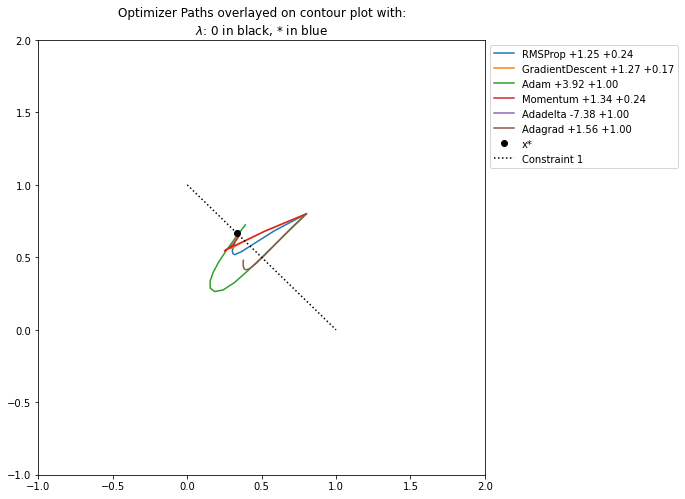

In [18]:
plt.figure(figsize=(8, 8))
plt.contour(grid[0], grid[1], zzero, samples // 2, alpha=0.25, linestyles='dashed', colors='k')
plt.contour(grid[0], grid[1], zstar, samples // 2, alpha=0.25, linestyles='dashed', colors='b')
leg = []
for optimizer in optimizers:
    
    step = optimizer.minimize(objective)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        x_ = sess.run(x)
        pts = [ x_[:, 0] ]
        for i in range(1,15):
            update(sess, step)
            x_ = sess.run(x)
            pts.append(x_[:, 0])
        pts = np.array(pts)
        plt.plot(pts[:,0], pts[:,1])
        l_, u_ = sess.run([l, u])
        leg.append('{} {} {}'.format(optimizer.get_name(), fa(l_[:,0], fmt='{:+4.2f}'), fa(u_[:,0], fmt='{:+4.2f}')))
plt.plot(xstar[0], xstar[1], 'o', c='k')
leg.append('x*')
plt.plot([0, 1], [1, 0], ls=':', c='k')
leg.append('Constraint 1')
plt.legend(leg, loc='upper left', bbox_to_anchor=(1, 1))
plt.title('\n'.join(['Optimizer Paths overlayed on contour plot with:',
                     '$\lambda$: 0 in black, * in blue'
                    ]))
plt.show()

## References

* ["Introduction TensorFlow - Optimization of Objective Functions", Wieschollek, 2017](http://patwie.com/tutorials/tensorflow-optimization.html)
* [ScipyOptimizerInterface](https://www.tensorflow.org/api_docs/python/tf/contrib/opt/ScipyOptimizerInterface)
* [Constraint optimization? #2025](https://github.com/tensorflow/tensorflow/issues/2025)
* [Constrained linear regression using Tensorflow](https://nipunbatra.github.io/blog/2017/nn-linear-regression-tensorflow.html)
* [SciPy portfolio optimization with grouped by industry bounds](https://stackoverflow.com/questions/44515880/scipy-portfolio-optimization-with-grouped-by-industry-bounds)
* [Numerical Optimization, Nocedal & Wright, 2006](http://www.bioinfo.org.cn/~wangchao/maa/Numerical_Optimization.pdf)